# Local PageRank - Local similarities in the nodes of a network

In [20]:
# Import useful libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import time
import queue

%matplotlib inline

In [5]:
# Import an undirected network
#path = 'data/networks/musae_facebook_22000.csv'
path = 'data/networks/as1998_500.txt'
G = nx.read_edgelist(path, delimiter='\t', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)

# Print info of the generated Graph
print(nx.info(G))

# Plot the adjacency matrix
#print('\nAdjacency matrix')
#plt.figure(figsize=(5,5))
#plt.spy(A, marker=',')
#plt.show()

# Initialize of the node target
node_target = 1
print('\nThe node target is', node_target, 'and its degree is', G.degree(node_target))

Name: 
Type: Graph
Number of nodes: 493
Number of edges: 1234
Average degree:   5.0061

The node target is 1 and its degree is 67


<h2>Classical approach using the power iteration algorithm</h2>

Elapsed time:  0.011470 seconds


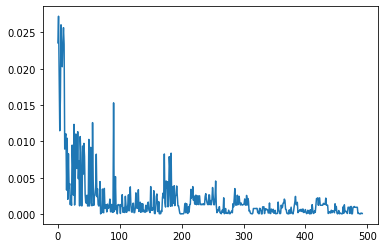

In [22]:
#compute PageRank algorith with power iteration (from network science)
def pageRank(M, t, iterations):
    N = M.shape[1]
    c = 0.85
    p = np.ones(N)/N

    for i in range(iterations):
        p = c * M * p + (1-c) * t #pagerank formula
        p = p/sum(p) #normalization

    return p


# dimension of the matrix
N = A.shape[0]

#teleport vector
# for normal pagerank all nodes have the same teleport probability
# for local pagerank only a subset of nodes have non-negative probabilty
t = np.ones(N)/N

start = time.time()
p = pageRank(A, t, 10)
stop = time.time()
print('Elapsed time: ', str(stop-start)[0:8], 'seconds')

plt.plot(p)
plt.show()

C:\Users\artur\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


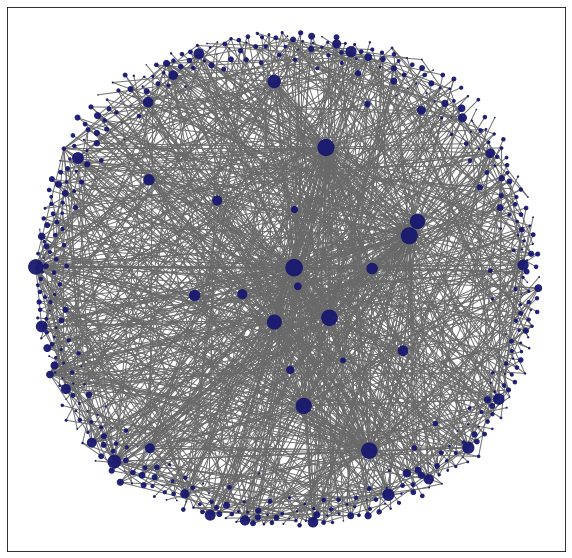

In [23]:
plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos=nx.spring_layout(G, seed = 10, k=1.7, iterations=50), node_size = p*10000, linewidth=1, with_labels=False, alpha=0.95, node_color = 'midnightblue', edge_color='dimgray')

<h2>Scalable approach using the results of Andersen, Chung, Lang. 2006</h2>

In [7]:
# Input:
# - the graph of the network
# - a dictionary of target nodes with, as value, the initial residual
#   (it can accept more than one target node)
# - the teleport constant alpha
# - a target precision epsilon
#
# Output:
# - a PageRank dictionary
#
def approximatePageRank(G, target_nodes, alpha, epsilon):

    # Initialization
    D = 2*G.number_of_edges()
    # PageRank
    p = {}
    # Residuals
    r = target_nodes.copy()
    # Degrees
    d = {}
    for n in target_nodes:
        d[n] = G.degree(n)

    # Calculate the initial queue based on the "r / d >= epsilon" condition
    queue = [key for key in r.keys() if (d[key] > 0) and (r[key]*D >= epsilon * d[key])]

    # Iterate until the queue is not empty
    while(queue):

        # Take the first element of the queue
        node_u = queue[0]
        
        # Perform the push operation
        # Update the PageRank dictionary
        if node_u in p:
            p[node_u] += (1-alpha) * r[node_u]
        else:
            p[node_u] = (1-alpha) * r[node_u]
        
        # Update the residual of the node u
        r[node_u] = alpha * r[node_u] / 2

        # Compute the new residuals of the neighbors of u
        for node_v in G.neighbors(node_u):
            if node_v in r:
                r[node_v] += r[node_u] / d[node_u]
            else:
                r[node_v] = r[node_u] / d[node_u]
                d[node_v] = G.degree(node_v)

        # Recompute the queue
        queue = [key for key in r.keys() if (d[key] > 0) and (r[key]*D >= epsilon * d[key])]

    return p

In [6]:
def arrayFromDict(p):

    # Get values and keys from the dictionary
    p_values = list(p.values())
    p_keys = np.array(list(p.keys()))

    # Normalize PageRank vector
    p_values = np.array(p_values) / sum(p_values)

    # Compute an array filling the missing nodes with zeros
    p_V = np.zeros(np.max(p_keys)+1)
    p_V[p_keys] = p_values

    return p_V

In [16]:
def matrix_L(G,alpha, epsilon):
    
    n = max(G.nodes)+1
    L = np.zeros((n,n))
    print(L.shape)
    
    for i in np.sort(G.nodes):
        #print(i)
        personalization_vector = {i:1}
        p = approximatePageRank(G, personalization_vector, alpha, epsilon)
        p = arrayFromDict(p)
        L[:,i] = np.concatenate((p, np.zeros(n-p.size)))
    
        
    return L

(11691, 11691)


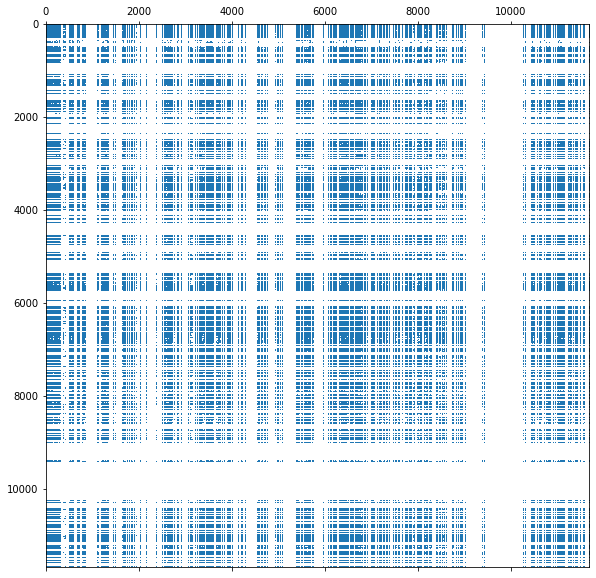

In [17]:
#CI METTE TANTO!!!!!
L = matrix_L(G, 0.85, 0.1)
plt.figure(figsize=(10,10))
plt.spy(L, marker=',')
plt.show()

In [9]:
# Initialize the parameters
personalization_vector = {node_target : 1}
alpha = 0.85
epsilon = 0.01

# Compute the PageRank dictionary with our implementation
start = time.time()
p = approximatePageRank(G, personalization_vector, alpha, epsilon)
stop = time.time()

print('Our implementation of the Approximate PageRank')
print('Elapsed time:', str(stop-start)[0:8], 'seconds')

our_p_vector = arrayFromDict(p)

Our implementation of the Approximate PageRank
Elapsed time: 3.003999 seconds


In [10]:
# Compute the PageRank dictionary with networkx implementation
start = time.time()
p = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None)
stop = time.time()

print('Networkx implementation of the PageRank')
print('Elapsed time:', str(stop-start)[0:8], 'seconds')

nx_p_vector = arrayFromDict(p)

Networkx implementation of the PageRank
Elapsed time: 0.080095 seconds


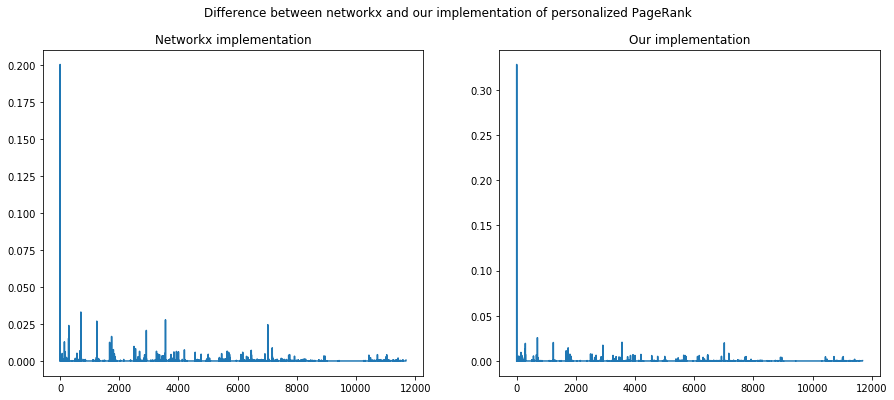

In [11]:
# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(nx_p_vector)
axs[0].set_title('Networkx implementation')
axs[1].plot(our_p_vector)
axs[1].set_title('Our implementation')
plt.show()

<h1>TASK 2</h1>
<h3>Speed up the algorithm using a FIFO queue. </h3>

In [12]:
# Input:
# - the graph of the network
# - a dictionary of target nodes with, as value, the initial residual
#   (it can accept more than one target node)
# - the teleport constant alpha
# - a target precision epsilon
#
# Output:
# - a PageRank dictionary
#
def approximatePageRank_queue(G, target_nodes, alpha, epsilon):

    # Initialization
    D = 2*G.number_of_edges()
    
    # PageRank
    p = {}
    
    # Residuals
    r = target_nodes.copy()
    
    # Create the FIFO queue
    q = queue.Queue()
    
    # Degrees
    d = {}
    
    for n in target_nodes:
        d[n] = G.degree(n)
        q.put(n)

    # Iterate until the queue is not empty
    while(q.qsize()>0):
        #print(q.qsize())
        #print(list(q.queue)[:(min(10,q.qsize()-1))])
        
        # Take the first element of the queue
        node_u = q.get()
        #get the next element if it doesn't satisfy the condition
        while(r[node_u]*D < epsilon*d[node_u]):
            node_u = q.get()
        
        # Perform the push operation
        # Update the PageRank dictionary
        if node_u in p:
            p[node_u] += (1-alpha) * r[node_u]
        else:
            p[node_u] = (1-alpha) * r[node_u]
        
        # Update the residual of the node u
        r[node_u] = alpha * r[node_u] / 2

        # Compute the new residuals of the neighbors of u
        for node_v in G.neighbors(node_u):
            if node_v in r:
                r[node_v] += r[node_u] / d[node_u]
            else:
                r[node_v] = r[node_u] / d[node_u]
                d[node_v] = G.degree(node_v)
                
            if d[node_v]>0 and r[node_v]*D >= epsilon*d[node_v] :
                q.put(node_v)
        
        if r[node_u]*D >= epsilon*d[node_u]:
            q.put(node_u)
        
    return p

<h3>Proof of concept for a speed up using linear composition of Basis Vector </h3> as in http://infolab.stanford.edu/~glenj/spws.pdf

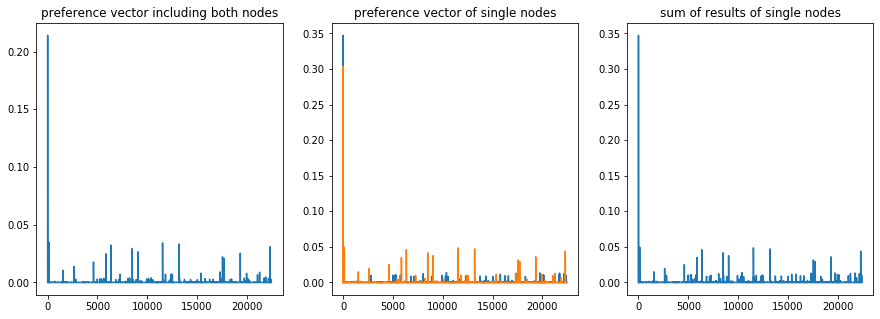

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

personalization_vector = {1:1, 2:2}
alpha = 0.85
epsilon = 1

p = approximatePageRank_queue(G, personalization_vector, alpha, epsilon)
combined_p = arrayFromDict(p)
axs[0].plot(combined_p)
axs[0].set_title('preference vector including both nodes')

p1 = approximatePageRank(G, {1:1}, alpha, epsilon)
vector_p1 = arrayFromDict(p1)
p2 = approximatePageRank(G, {2:1}, alpha, epsilon)
vector_p2 = arrayFromDict(p2)
axs[1].plot(vector_p1)
axs[1].plot(vector_p2)
axs[1].set_title('preference vector of single nodes')

l = max(vector_p1.size, vector_p2.size)
if vector_p1.size > vector_p2.size:
    vector_p2 = np.append(vector_p2, np.zeros(l-vector_p2.size))
else:
    vector_p1 = np.append(vector_p1, np.zeros(l-vector_p1.size))

vector_p12 = vector_p1 + vector_p2
axs[2].plot(vector_p12)
axs[2].set_title('sum of results of single nodes')

plt.show()

In [ ]:
# select the node target
node_target = 100

# initialize the list with the stats
nodes_vector = [0] * 4
our_times_vector = [0] * 4
nx_times_vector = [0] * 4

# init some parameters
personalization_vector = {node_target : 1}
alpha = 0.85
epsilon = 1e-5

In [ ]:
# Import a network with about 7k nodes
path = 'data/networks/lastfm_asia_7000.csv'
G = nx.read_edgelist(path, delimiter=',', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))
print()

# Save the number of nodes
nodes_vector[0] = G.number_of_nodes()

# Compute our Personalized PageRank and save the execution time
start = time.time()
p = approximatePageRank(G, personalization_vector, alpha, epsilon)
stop = time.time()
t = str(stop-start)[0:8]
our_times_vector[0] = float(t)
print('Our implementation of ApproximatePageRank of the node', node_target)
print('Elapsed time:', t, 'seconds')
p_vector = arrayFromDict(p)

# Compute networkx PageRank and save the execution time
start = time.time()
pr = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None)
stop = time.time()
t = str(stop-start)[0:8]
nx_times_vector[0] = float(t)
print('Networkx implementation of PageRank')
print('Elapsed time:', t, 'seconds\n')
pr_vector = arrayFromDict(pr)

# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(pr_vector)
axs[0].set_title('Networkx implementation')
axs[1].plot(p_vector)
axs[1].set_title('Our implementation')
plt.show()

In [ ]:
# Import a network with about 22k nodes
path = 'data/networks/musae_facebook_22000.csv'
G = nx.read_edgelist(path, delimiter=',', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))
print()

# Save the number of nodes
nodes_vector[1] = G.number_of_nodes()

# Compute our Personalized PageRank and save the execution time
start = time.time()
p = approximatePageRank(G, personalization_vector, alpha, epsilon)
stop = time.time()
t = str(stop-start)[0:8]
our_times_vector[1] = float(t)
print('Our implementation of ApproximatePageRank of the node', node_target)
print('Elapsed time:', t, 'seconds')
p_vector = arrayFromDict(p)

# Compute networkx PageRank and save the execution time
start = time.time()
pr = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None)
stop = time.time()
t = str(stop-start)[0:8]
nx_times_vector[1] = float(t)
print('Networkx implementation of PageRank')
print('Elapsed time:', t, 'seconds\n')
pr_vector = arrayFromDict(pr)

# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(pr_vector)
axs[0].set_title('Networkx implementation')
axs[1].plot(p_vector)
axs[1].set_title('Our implementation')
plt.show()

In [ ]:
# Import a network with about 335k nodes
path = 'data/networks/amazon_335000.txt'
G = nx.read_edgelist(path, delimiter='\t', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))
print()

# Save the number of nodes
nodes_vector[2] = G.number_of_nodes()

# Compute our Personalized PageRank and save the execution time
start = time.time()
p = approximatePageRank(G, personalization_vector, alpha, epsilon)
stop = time.time()
t = str(stop-start)[0:8]
our_times_vector[2] = float(t)
print('Our implementation of ApproximatePageRank of the node', node_target)
print('Elapsed time:', t, 'seconds')
p_vector = arrayFromDict(p)

# Compute networkx PageRank and save the execution time
start = time.time()
pr = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None)
stop = time.time()
t = str(stop-start)[0:8]
nx_times_vector[2] = float(t)
print('Networkx implementation of PageRank')
print('Elapsed time:', t, 'seconds\n')
pr_vector = arrayFromDict(pr)

# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(pr_vector)
axs[0].set_title('Networkx implementation')
axs[1].plot(p_vector)
axs[1].set_title('Our implementation')
plt.show()

In [ ]:
# Import a network with about 1135k nodes
path = 'data/networks/youtube_1135000.txt'
G = nx.read_edgelist(path, delimiter='\t', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))
print()

# Save the number of nodes
nodes_vector[3] = G.number_of_nodes()

# Compute our Personalized PageRank and save the execution time
start = time.time()
p = approximatePageRank(G, personalization_vector, alpha, epsilon)
stop = time.time()
t = str(stop-start)[0:8]
our_times_vector[3] = float(t)
print('Our implementation of ApproximatePageRank of the node', node_target)
print('Elapsed time:', t, 'seconds')
p_vector = arrayFromDict(p)

# Compute networkx PageRank and save the execution time
start = time.time()
pr = nx.pagerank(G, personalization=personalization_vector, max_iter=20, weight=None)
stop = time.time()
t = str(stop-start)[0:8]
nx_times_vector[3] = float(t)
print('Networkx implementation of PageRank')
print('Elapsed time:', t, 'seconds\n')
pr_vector = arrayFromDict(pr)

# Plot the difference between the two solutions
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Difference between networkx and our implementation of personalized PageRank')
axs[0].plot(pr_vector)
axs[0].set_title('Networkx implementation')
axs[1].plot(p_vector)
axs[1].set_title('Our implementation')
plt.show()

In [ ]:
# Plot the execution time over the number of the nodes of both the implementation
plt.figure(figsize=(8,5))
plt.plot(nodes_vector, nx_times_vector, 'r*-', label='networkx PR')
plt.plot(nodes_vector, our_times_vector, 'bo-', label='our approximatePR')
plt.title('Execution time over the number of nodes')
plt.xlabel('# nodes')
plt.ylabel('time [s]')
plt.legend()
plt.show()